# Audio

## Setup and imports

In [ ]:
!pip install tensorflow tensorflow_hub librosa
import librosa
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout


## Downloading the Dataset

In [ ]:
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip master.zip -d dataset


--2024-05-01 23:34:48--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master [following]
--2024-05-01 23:34:48--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [    <=>             ]  15.66M  19.5MB/s    in 0.8s    

2024-05-01 23:34:49 (19.5 MB/s) - ‘master.zip’ saved [16421388]

Archive:  master.zip
4c3b0983b1b7f46ec5e49ca527e8e8844a81107e
   creating: dataset/fre

## Load the pre-trained YAMNet model


In [ ]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')




In [ ]:
def extract_features(file_path, model):
    # Load an audio file
    wave, sr = librosa.load(file_path, sr=16000)
    # Ensure the waveform is exactly 16,000 samples long
    if len(wave) > 16000:
        wave = wave[:16000]  # Trim to the first 16,000 samples
    else:
        padding = 16000 - len(wave)  # Calculate padding
        wave = np.pad(wave, (0, padding), 'constant')  # Pad waveform

    # Pass waveform through the model to get embeddings
    scores, embeddings, spectrogram = model(wave)
    return embeddings.numpy().mean(axis=0)
# Prepare data
features, labels = [], []
data_dir = '/content/dataset/free-spoken-digit-dataset-master/recordings'
for filename in os.listdir(data_dir):
    if filename.endswith('.wav'):
        digit = int(filename[0])  # Assuming filename format is {digit}_...
        path = os.path.join(data_dir, filename)
        emb = extract_features(path, yamnet_model)
        features.append(emb)
        labels.append(digit)

features = np.array(features)
labels = np.array(labels)


## Preparing the dataset and training the model

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Build a simple model on top of YAMNet embeddings
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
75/75 [==============================] - 3s 6ms/step - loss: 2.3994 - accuracy: 0.1267 - val_loss: 2.2742 - val_accuracy: 0.1133
Epoch 2/50
75/75 [==============================] - 0s 4ms/step - loss: 2.2647 - accuracy: 0.1417 - val_loss: 2.2409 - val_accuracy: 0.1667
Epoch 3/50
75/75 [==============================] - 0s 4ms/step - loss: 2.2240 - accuracy: 0.1550 - val_loss: 2.2054 - val_accuracy: 0.1550
Epoch 4/50
75/75 [==============================] - 0s 4ms/step - loss: 2.1954 - accuracy: 0.1675 - val_loss: 2.1687 - val_accuracy: 0.1667
Epoch 5/50
75/75 [==============================] - 0s 4ms/step - loss: 2.1610 - accuracy: 0.1879 - val_loss: 2.1467 - val_accuracy: 0.1667
Epoch 6/50
75/75 [==============================] - 0s 4ms/step - loss: 2.1398 - accuracy: 0.1917 - val_loss: 2.1261 - val_accuracy: 0.1833
Epoch 7/50
75/75 [==============================] - 0s 4ms/step - loss: 2.1360 - accuracy: 0.1867 - val_loss: 2.1035 - val_accuracy: 0.1883
Epoch 8/50
75/75 [==

## Testing the model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


19/19 [==============================] - 0s 4ms/step - loss: 1.9086 - accuracy: 0.2633
Test Loss: 1.9086064100265503, Test Accuracy: 0.2633333206176758


In [ ]:
import IPython.display as ipd


In [ ]:
def load_and_predict(file_path, model, yamnet_model):
    # Load and process the audio file
    wave, sr = librosa.load(file_path, sr=16000)
    if len(wave) > 16000:
        wave = wave[:16000]  # Trim to the first 16,000 samples
    else:
        padding = 16000 - len(wave)  # Calculate padding
        wave = np.pad(wave, (0, padding), 'constant')  # Pad waveform

    # Extract features using YAMNet
    scores, embeddings, spectrogram = yamnet_model(wave)
    embeddings = embeddings.numpy().mean(axis=0)

    # Predict using the trained model
    prediction = model.predict(np.array([embeddings]))
    predicted_digit = np.argmax(prediction)

    return predicted_digit

def play_audio(file_path):
    return ipd.Audio(file_path)


In [ ]:
# Path to the audio file you want to test
test_audio_path = '/content/dataset/free-spoken-digit-dataset-master/recordings/0_jackson_0.wav'  # Update as needed

# Play the audio
ipd.display(play_audio(test_audio_path))

# Predict the digit
predicted_digit = load_and_predict(test_audio_path, model, yamnet_model)
print(f"The predicted digit is: {predicted_digit}")


1/1 [==============================] - 0s 142ms/step
The predicted digit is: 0


## Test a susbet (20 sample) of the data

In [ ]:
import random
import IPython.display as ipd
import librosa
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub

# Function to load audio, predict digit, and display results
def load_and_predict(file_path, model, yamnet_model):
    # Load and process the audio file
    wave, sr = librosa.load(file_path, sr=16000)
    if len(wave) > 16000:
        wave = wave[:16000]  # Trim to the first 16,000 samples
    else:
        padding = 16000 - len(wave)  # Calculate padding
        wave = np.pad(wave, (0, padding), 'constant')  # Pad waveform

    # Extract features using YAMNet
    scores, embeddings, spectrogram = yamnet_model(wave)
    embeddings = embeddings.numpy().mean(axis=0)

    # Predict using the trained model
    prediction = model.predict(np.array([embeddings]))
    predicted_digit = np.argmax(prediction)

    return predicted_digit

# Function to randomly select and test multiple files
def test_multiple_files(directory, model, yamnet_model, num_samples=20):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]
    sampled_files = random.sample(files, num_samples)

    results = []
    for file_path in sampled_files:
        predicted_digit = load_and_predict(file_path, model, yamnet_model)
        results.append((file_path, predicted_digit))
        print(f"File: {file_path} - Predicted Digit: {predicted_digit}")
        ipd.display(ipd.Audio(file_path))

    return results

# Path to the dataset directory
data_dir = '/content/dataset/free-spoken-digit-dataset-master/recordings'

# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load your trained model (ensure it's loaded or trained in your session)
# model = ... (your model here)

# Test the model on 20 random audio files
test_results = test_multiple_files(data_dir, model, yamnet_model, num_samples=20)


1/1 [==============================] - 0s 24ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_theo_40.wav - Predicted Digit: 2


1/1 [==============================] - 0s 23ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/5_theo_34.wav - Predicted Digit: 2


1/1 [==============================] - 0s 22ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/3_theo_28.wav - Predicted Digit: 2


1/1 [==============================] - 0s 25ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/6_jackson_36.wav - Predicted Digit: 6


1/1 [==============================] - 0s 27ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/9_lucas_14.wav - Predicted Digit: 2


1/1 [==============================] - 0s 36ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/3_theo_23.wav - Predicted Digit: 3


1/1 [==============================] - 0s 30ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/6_nicolas_11.wav - Predicted Digit: 2


1/1 [==============================] - 0s 23ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_nicolas_44.wav - Predicted Digit: 2


1/1 [==============================] - 0s 29ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/0_jackson_16.wav - Predicted Digit: 0


1/1 [==============================] - 0s 26ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_nicolas_37.wav - Predicted Digit: 2


1/1 [==============================] - 0s 25ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/5_lucas_38.wav - Predicted Digit: 2


1/1 [==============================] - 0s 27ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/7_george_29.wav - Predicted Digit: 7


1/1 [==============================] - 0s 32ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/9_george_11.wav - Predicted Digit: 2


1/1 [==============================] - 0s 30ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/6_george_28.wav - Predicted Digit: 2


1/1 [==============================] - 0s 33ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/5_yweweler_21.wav - Predicted Digit: 2


1/1 [==============================] - 0s 26ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/0_jackson_41.wav - Predicted Digit: 0


1/1 [==============================] - 0s 27ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_jackson_19.wav - Predicted Digit: 2


1/1 [==============================] - 0s 26ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/1_yweweler_19.wav - Predicted Digit: 2


1/1 [==============================] - 0s 26ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_jackson_49.wav - Predicted Digit: 2


1/1 [==============================] - 0s 17ms/step
File: /content/dataset/free-spoken-digit-dataset-master/recordings/4_yweweler_14.wav - Predicted Digit: 2


## improving accuracy by augmentation

In [ ]:
import librosa
import numpy as np
import IPython.display as ipd
import tensorflow as tf
import tensorflow_hub as hub
import random
import os


In [ ]:
import numpy as np
import librosa

def augment_audio(y, sr):
    # Time-stretch by a factor randomly chosen between 0.8 and 1.2
    y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))

    # Pitch-shift by n steps randomly chosen between -5 and 5
    y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-5, 5))

    # Add random noise
    noise = np.random.randn(len(y)) * 0.005
    y += noise

    return y


In [ ]:
def load_and_preprocess(file_path, model, augment=False):
    # Load audio file
    wave, sr = librosa.load(file_path, sr=16000)
    # Apply augmentation if specified
    if augment:
        wave = augment_audio(wave, sr)

    # Ensure the waveform is exactly 16,000 samples long
    if len(wave) > 16000:
        wave = wave[:16000]  # Trim to the first 16,000 samples
    else:
        padding = 16000 - len(wave)  # Calculate padding
        wave = np.pad(wave, (0, padding), 'constant')  # Pad waveform

    # Extract features using YAMNet
    scores, embeddings, spectrogram = model(wave)
    embeddings = embeddings.numpy().mean(axis=0)

    return wave, embeddings


In [ ]:
def predict_and_play(file_path, model, yamnet_model, augment=False):
    wave, embeddings = load_and_preprocess(file_path, yamnet_model, augment=augment)
    prediction = model.predict(np.array([embeddings]))
    predicted_digit = np.argmax(prediction)

    # Play audio
    ipd.display(ipd.Audio(wave, rate=16000))
    print(f"Predicted Digit: {predicted_digit}")


### Testing the augmented data

In [ ]:
# Path to the dataset directory
data_dir = '/content/dataset/free-spoken-digit-dataset-master/recordings'

# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Select a random file to test
file_path = random.choice([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')])

# Test without augmentation
print("Original Audio:")
predict_and_play(file_path, model, yamnet_model, augment=False)

# Test with augmentation
print("Augmented Audio:")
predict_and_play(file_path, model, yamnet_model, augment=True)


Original Audio:
1/1 [==============================] - 0s 20ms/step


Predicted Digit: 5
Augmented Audio:
1/1 [==============================] - 0s 19ms/step


Predicted Digit: 2


# Images


## Setup and Import

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Downloading the dataset

In [ ]:
# Download and prepare the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = path_to_zip.rsplit('/', 1)[0] + '/cats_and_dogs_filtered'

train_dir = PATH + '/train'
validation_dir = PATH + '/validation'


68606236/68606236 [==============================] - 1s 0us/step


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Creating and training the model

In [ ]:
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)  # Ensure binary classification
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // BATCH_SIZE)


Epoch 1/10
62/62 [==============================] - 23s 282ms/step - loss: 0.2521 - accuracy: 0.8908 - val_loss: 0.0993 - val_accuracy: 0.9627
Epoch 2/10
62/62 [==============================] - 19s 308ms/step - loss: 0.1510 - accuracy: 0.9355 - val_loss: 0.0845 - val_accuracy: 0.9698
Epoch 3/10
62/62 [==============================] - 17s 270ms/step - loss: 0.1389 - accuracy: 0.9451 - val_loss: 0.0924 - val_accuracy: 0.9597
Epoch 4/10
62/62 [==============================] - 17s 275ms/step - loss: 0.1154 - accuracy: 0.9533 - val_loss: 0.0823 - val_accuracy: 0.9657
Epoch 5/10
62/62 [==============================] - 19s 303ms/step - loss: 0.1073 - accuracy: 0.9548 - val_loss: 0.0925 - val_accuracy: 0.9597
Epoch 6/10
62/62 [==============================] - 18s 290ms/step - loss: 0.1218 - accuracy: 0.9492 - val_loss: 0.1019 - val_accuracy: 0.9587
Epoch 7/10
62/62 [==============================] - 17s 274ms/step - loss: 0.1062 - accuracy: 0.9543 - val_loss: 0.0828 - val_accuracy: 0.9677

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              metrics=['accuracy'])

history_fine = model.fit(train_generator,
                         steps_per_epoch=train_generator.samples // BATCH_SIZE,
                         epochs=5,  # Additional epochs for fine-tuning
                         validation_data=validation_generator,
                         validation_steps=validation_generator.samples // BATCH_SIZE)


Epoch 1/5
62/62 [==============================] - 30s 293ms/step - loss: 0.3190 - accuracy: 0.8699 - val_loss: 0.0941 - val_accuracy: 0.9677
Epoch 2/5
62/62 [==============================] - 17s 278ms/step - loss: 0.1875 - accuracy: 0.9268 - val_loss: 0.0887 - val_accuracy: 0.9728
Epoch 3/5
62/62 [==============================] - 18s 296ms/step - loss: 0.1695 - accuracy: 0.9324 - val_loss: 0.0847 - val_accuracy: 0.9738
Epoch 4/5
62/62 [==============================] - 18s 295ms/step - loss: 0.1681 - accuracy: 0.9334 - val_loss: 0.0828 - val_accuracy: 0.9738
Epoch 5/5
62/62 [==============================] - 17s 279ms/step - loss: 0.1356 - accuracy: 0.9466 - val_loss: 0.0800 - val_accuracy: 0.9738


## Testing the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image


In [ ]:
def load_and_prepare_image(file_path, img_size=(160, 160)):
    img = image.load_img(file_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array /= 255.  # Scale the image like the training set
    return img_array


In [ ]:
def predict_image(model, img_array):
    predictions = model.predict(img_array)
    predicted_class = 'Dog' if predictions[0] > 0.5 else 'Cat'
    return predicted_class, predictions[0][0]  # Access the first element if predictions is a multi-dimensional array


1/1 [==============================] - 0s 23ms/step


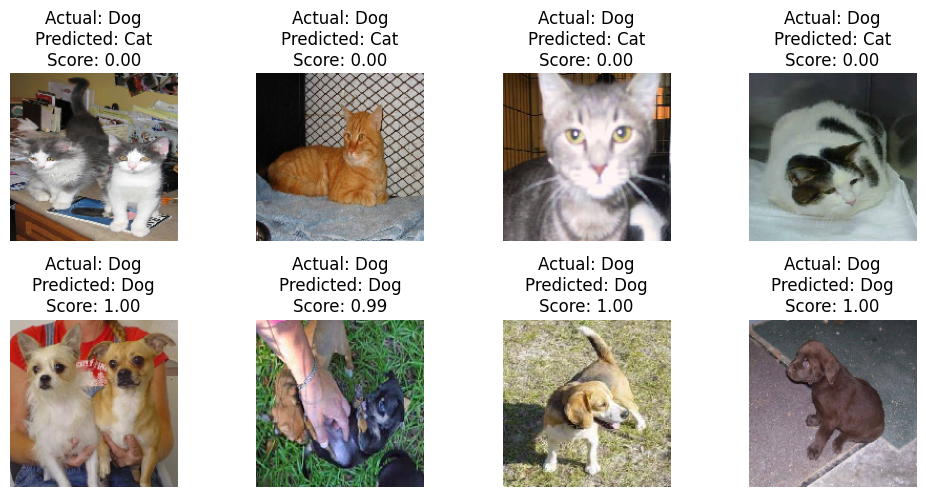

In [ ]:
def display_predictions(paths, model):
    plt.figure(figsize=(10, 10))
    for i, file_path in enumerate(paths):
        img_array = load_and_prepare_image(file_path)
        predicted_class, score = predict_image(model, img_array)
        actual_class = 'Dog' if 'dog' in file_path.lower() else 'Cat'
        plt.subplot(4, 4, i + 1)
        plt.imshow(img_array[0])
        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nScore: {score:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
import os
test_images = [os.path.join(validation_dir, 'cats', img) for img in os.listdir(os.path.join(validation_dir, 'cats'))[:4]]
test_images += [os.path.join(validation_dir, 'dogs', img) for img in os.listdir(os.path.join(validation_dir, 'dogs'))[:4]]

display_predictions(test_images, model)


# Video

## Setup and import

In [ ]:
!pip install pytube


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install pytube

from pytube import YouTube

def download_youtube_videos(video_urls, save_path='/content/videos/'):
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for url in video_urls:
        try:
            yt = YouTube(url)
            # Select the best progressive download stream (contains both audio and video)
            stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
            stream.download(save_path)
            print(f"Downloaded {url} successfully.")
        except Exception as e:
            print(f"Failed to download {url}: {str(e)}")

# List of YouTube video URLs
video_urls = [
    'https://www.youtube.com/watch?v=2Nlbro2MNBs',  # Sample nature video
    'https://www.youtube.com/watch?v=HbeoRP8cDcI',  # Sample nature video
]

download_youtube_videos(video_urls)


Downloaded https://www.youtube.com/watch?v=2Nlbro2MNBs successfully.
Failed to download https://www.youtube.com/watch?v=HbeoRP8cDcI: HbeoRP8cDcI is unavailable


In [ ]:
!pip install opencv-python-headless  # Headless version is suitable for server environments
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


## Getting demo videos directly from youtube

In [ ]:
!ls -l /content/videos/


total 574260
-rw-r--r-- 1 root root 588037823 May  2 00:46 'Tom Campbell in Calgary Theory of MBT (Sat) 13.mp4'


In [ ]:
from pytube import YouTube

# Specify a valid YouTube video ID by replacing 'dQw4w9WgXcQ' with the ID of the video you want to download
video_url = 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'  # Example with a real video ID

# Attempt to download the video
try:
    yt = YouTube(video_url)
    stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if stream:
        stream.download(output_path='/content/videos/', filename='downloaded_video.mp4')
        print("Video downloaded successfully!")
    else:
        print("No suitable stream found for this video.")
except Exception as e:
    print(f"An error occurred: {e}")


Video downloaded successfully!


## Setting up the model

In [ ]:
!pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def extract_frames(video_path, frames_per_video=16):
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_step = total_frames // frames_per_video
    frames = []

    for i in range(frames_per_video):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i * frames_step)
        success, image = vidcap.read()
        if success:
            # Convert the image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(image)
        else:
            print(f"Frame capture failed for frame number: {i * frames_step}")
            break

    vidcap.release()
    return np.array(frames)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential

def build_video_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the convolutional base

    model = Sequential([
        TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(32),
        Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_video_model()
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 7, 7, 1280   2257984   
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, None, 1280)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                168064    
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2426081 (9.25 MB)
Trainable params: 168097 (656.63 KB)
Non-trainable params: 2257984 (8.61 MB)
________________

In [ ]:
from pytube import YouTube

def download_youtube_video(url, output_path='/content/videos/', filename='video.mp4'):
    try:
        yt = YouTube(url)
        # Select the best quality video stream that includes both video and audio
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        if stream:
            stream.download(output_path=output_path, filename=filename)
            print(f"Downloaded video saved to {output_path}{filename}")
            return f"{output_path}{filename}"
        else:
            print("No suitable stream found.")
    except Exception as e:
        print(f"Failed to download video: {str(e)}")
        return None


In [ ]:
video_url = 'https://www.youtube.com/watch?v=nqye02H_H6I'
downloaded_video_path = download_youtube_video(video_url, filename='my_downloaded_video.mp4')


check_video(downloaded_video_path)


Downloaded video saved to /content/videos/my_downloaded_video.mp4
/content/videos/my_downloaded_video.mp4 can be opened


In [ ]:
def check_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        print(f"{video_path} can be opened")
        cap.release()
    else:
        print(f"{video_path} cannot be opened")

check_video('/content/videos/my_downloaded_video.mp4')

/content/videos/my_downloaded_video.mp4 can be opened


## Extracting the frames from the video provided

In [ ]:
!pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_frames(video_path, frames_per_video=16):
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_step = total_frames // frames_per_video
    frames = []

    for i in range(frames_per_video):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i * frames_step)
        success, image = vidcap.read()
        if success:
            # Convert the image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(image)
        else:
            print(f"Frame capture failed for frame number: {i * frames_step}")
            break

    vidcap.release()
    return np.array(frames)

# Extract frames from the downloaded video
frames = extract_frames('/content/videos/my_downloaded_video.mp4', frames_per_video=16)


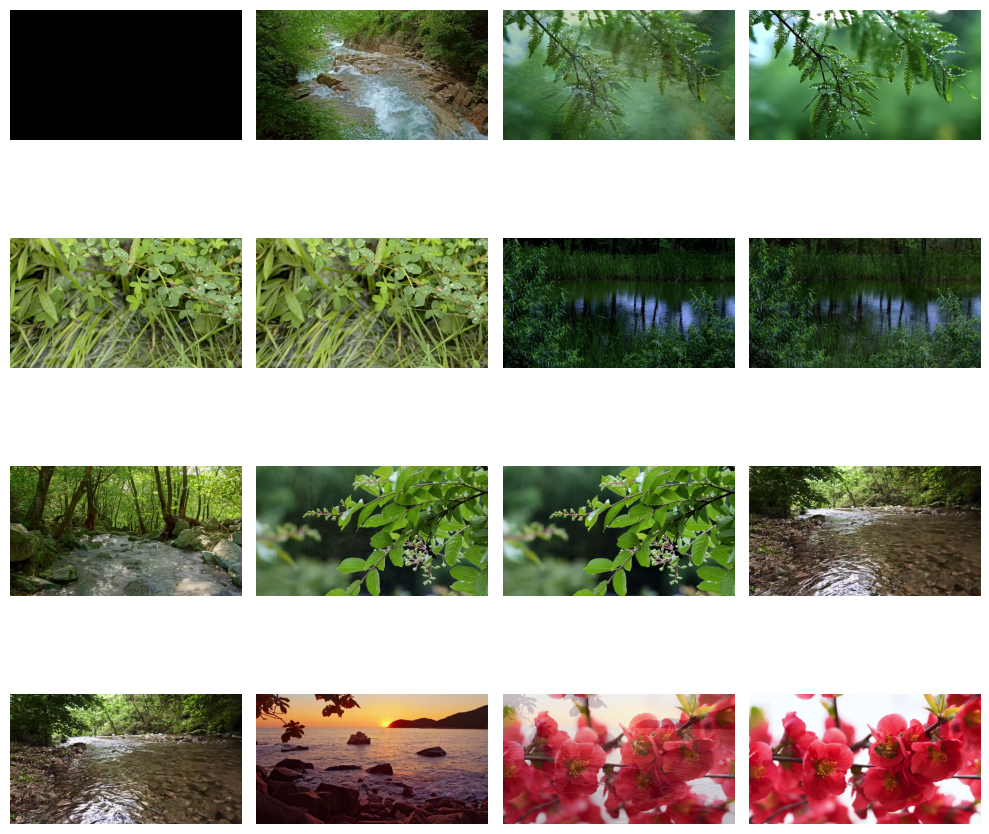

In [ ]:
plt.figure(figsize=(10, 10))
for i, frame in enumerate(frames):
    plt.subplot(4, 4, i + 1)
    plt.imshow(frame)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

def build_video_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the convolutional base

    model = Sequential([
        TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(32),
        Dense(1, activation='sigmoid')  # Assuming binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_video_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, None, 7, 7, 1280   2257984   
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1280)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 32)                168064    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2426081 (9.25 MB)
Trainable params: 168097 (656.63 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
import cv2
import numpy as np

def extract_frames(video_path, frames_per_video=16, size=(224, 224)):
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_step = total_frames // frames_per_video
    frames = []

    for i in range(frames_per_video):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, i * frames_step)
        success, image = vidcap.read()
        if success:
            # Resize frame
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            # Convert the image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames.append(image)
        else:
            print(f"Frame capture failed for frame number: {i * frames_step}")
            break

    vidcap.release()
    return np.array(frames)


In [ ]:

video_paths = ['/content/videos/my_downloaded_video.mp4']
labels = [0]

X_train = []
y_train = []

for video_path, label in zip(video_paths, labels):
    frames = extract_frames(video_path, frames_per_video=16)
    if frames.size > 0:
        X_train.append(frames)
        y_train.append(label)
    else:
        print(f"Failed to extract frames from {video_path}")

# Convert lists to numpy arrays for training
X_train = np.array(X_train)
y_train = np.array(y_train)

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1, 16, 224, 224, 3)
y_train shape: (1,)


In [ ]:
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

def build_video_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the convolutional base

    model = Sequential([
        TimeDistributed(base_model, input_shape=(None, 224, 224, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ensure the model is built and compiled only once
model = build_video_model()

# Assuming X_train and y_train are already properly prepared
if X_train.size > 0 and y_train.size > 0:
    history = model.fit(X_train, y_train, epochs=10, batch_size=1)
else:
    print("Training data is not available or valid.")


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.7417 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 488ms/step - loss: 0.6997 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 478ms/step - loss: 0.3510 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 448ms/step - loss: 0.2293 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 482ms/step - loss: 0.1748 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 497ms/step - loss: 0.1468 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 479ms/step - loss: 0.1287 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 1s 512ms/step - loss: 0.1142 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 477ms/step - loss: 0.1014 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 498ms/step - loss: 0.0898 - accuracy: 1.0000


In [ ]:
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, 16, 224, 224, 3)
print(f"y_train shape: {y_train.shape}")  # Should match the number of samples


X_train shape: (1, 16, 224, 224, 3)
y_train shape: (1,)


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 7, 7, 1280   2257984   
 stributed)                  )                                   
                                                                 
 time_distributed_5 (TimeDi  (None, None, 1280)        0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 32)                168064    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2426081 (9.25 MB)
Trainable params: 168097 (656.63 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
